In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from timple.timedelta import strftimedelta
import fastf1 as ff1
import fastf1.plotting as ff1pl
from fastf1.core import Laps
import re
from PIL import Image
import numpy as np

In [2]:
ff1.Cache.enable_cache('../cache')
ff1pl.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False)

In [11]:
year, event, event_type = 2023, 'miami', 'Q'
session = ff1.get_session(year, event, event_type)
session.load()

core           INFO 	Loading data for Miami Grand Prix - Qualifying [v2.3.1]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
C:\Users\getou\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(new_last).reset_index(drop=True)
C:\Users\getou\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], 

In [4]:
drivers = pd.unique(session.laps['Driver'])
print(drivers)

['PER' 'ALO' 'SAI' 'MAG' 'GAS' 'RUS' 'LEC' 'OCO' 'VER' 'BOT' 'ALB' 'HUL'
 'HAM' 'ZHO' 'DEV' 'NOR' 'TSU' 'STR' 'PIA' 'SAR']


In [5]:
list_fastest_laps = list()
for drv in drivers:
    drvs_fastest_lap = session.laps.pick_driver(drv).pick_fastest()
    list_fastest_laps.append(drvs_fastest_lap)
fastest_laps = Laps(list_fastest_laps).sort_values(by='LapTime').reset_index(drop=True)

In [6]:
pole_lap = fastest_laps.pick_fastest().dropna()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']
print(fastest_laps[['Driver', 'LapTime', 'LapTimeDelta']].dropna())

   Driver                LapTime           LapTimeDelta
0     VER 0 days 00:01:26.814000        0 days 00:00:00
1     PER 0 days 00:01:26.841000 0 days 00:00:00.027000
2     ALO 0 days 00:01:27.202000 0 days 00:00:00.388000
3     SAI 0 days 00:01:27.349000 0 days 00:00:00.535000
4     BOT 0 days 00:01:27.564000 0 days 00:00:00.750000
5     MAG 0 days 00:01:27.767000 0 days 00:00:00.953000
6     GAS 0 days 00:01:27.786000 0 days 00:00:00.972000
7     ALB 0 days 00:01:27.795000 0 days 00:00:00.981000
8     RUS 0 days 00:01:27.804000 0 days 00:00:00.990000
9     LEC 0 days 00:01:27.861000 0 days 00:00:01.047000
10    HUL 0 days 00:01:27.903000 0 days 00:00:01.089000
11    OCO 0 days 00:01:27.935000 0 days 00:00:01.121000
12    HAM 0 days 00:01:27.975000 0 days 00:00:01.161000
13    ZHO 0 days 00:01:28.091000 0 days 00:00:01.277000
14    NOR 0 days 00:01:28.394000 0 days 00:00:01.580000
15    DEV 0 days 00:01:28.395000 0 days 00:00:01.581000
16    TSU 0 days 00:01:28.429000 0 days 00:00:01

In [67]:
filtered_fastest_laps = fastest_laps.dropna(subset=['Team'])
def lap_time_delta_to_string(delta):
    if pd.isna(delta):
        return ''
    minutes, remainder = divmod(delta.seconds, 60)
    seconds = remainder + delta.microseconds / 1e6
    return f"+{seconds:05.3f}s"

team_colors = list()
for index, lap in filtered_fastest_laps.iterrows():
    color = ff1.plotting.team_color(lap['Team'])
    team_colors.append(color)

modified_fastest_laps = filtered_fastest_laps.copy()

In [73]:
lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')
plot_width = 10
plot_height = 10
plot_size = [plot_width, plot_height]
# Calculate font sizes based on the plot size
title_font_size = int(2.15 * plot_height)  # Adjust the 0.15 multiplier to your liking
axis_label_font_size = int(1.5 * plot_height)  # Adjust the 0.1 multiplier to your liking
plot_title = f"{session.event['EventName']} {session.event.year} {event_type} Gap To Fastest\n Fastest Lap: {lap_time_string} ({pole_lap['Driver']})"
plot_filename = re.sub(r'\W+', '', plot_title.replace("\n", " ")) + ".png"
logo_path = '../RCKMG_logo.png'
logo_img = Image.open(logo_path)

In [69]:
def add_logo():
    # Define the new width and height for the logo
    new_width = 35
    new_height = 35
    # Resize the logo
    logo_resized = logo_img.resize((new_width, new_height))
    logo_resized_np = np.array(logo_resized)
    logo_x = 425
    logo_y = 807
    fig.figimage(logo_resized_np, xo=logo_x, yo=logo_y, zorder=1, origin='upper', alpha=1)

def intervals(ax):
    # INTERVALS
    modified_fastest_laps['Interval'] = modified_fastest_laps['LapTime'].diff()
    modified_fastest_laps['IntervalString'] = modified_fastest_laps['Interval'].apply(lap_time_delta_to_string)
    # Add the interval on the bars
    for i, rect in enumerate(ax.containers[0]):
        x = rect.get_width()
        y = rect.get_y() + rect.get_height() / 2

        # Display "Leader" for the first bar and interval for the rest
        if i == 0:
            text = "Leader"
        else:
            text = modified_fastest_laps.iloc[i]['IntervalString']

        ax.text(x, y, text, ha='left', va='center', size=axis_label_font_size)

def gap_to_leader(ax):
    # GAP to Leader
    modified_fastest_laps['LapTimeDeltaString'] = modified_fastest_laps['LapTimeDelta'].apply(lap_time_delta_to_string)
    #Add the gap to the leader on the bars
    bars = ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
                   color=team_colors, edgecolor='grey')
    for i, rect in enumerate(bars[:len(modified_fastest_laps)]):
        x = rect.get_width()
        y = rect.get_y() + rect.get_height() / 2
        gap = modified_fastest_laps.iloc[i]['LapTimeDeltaString']
        ax.text(x, y, gap, ha='left', va='center', size=15)

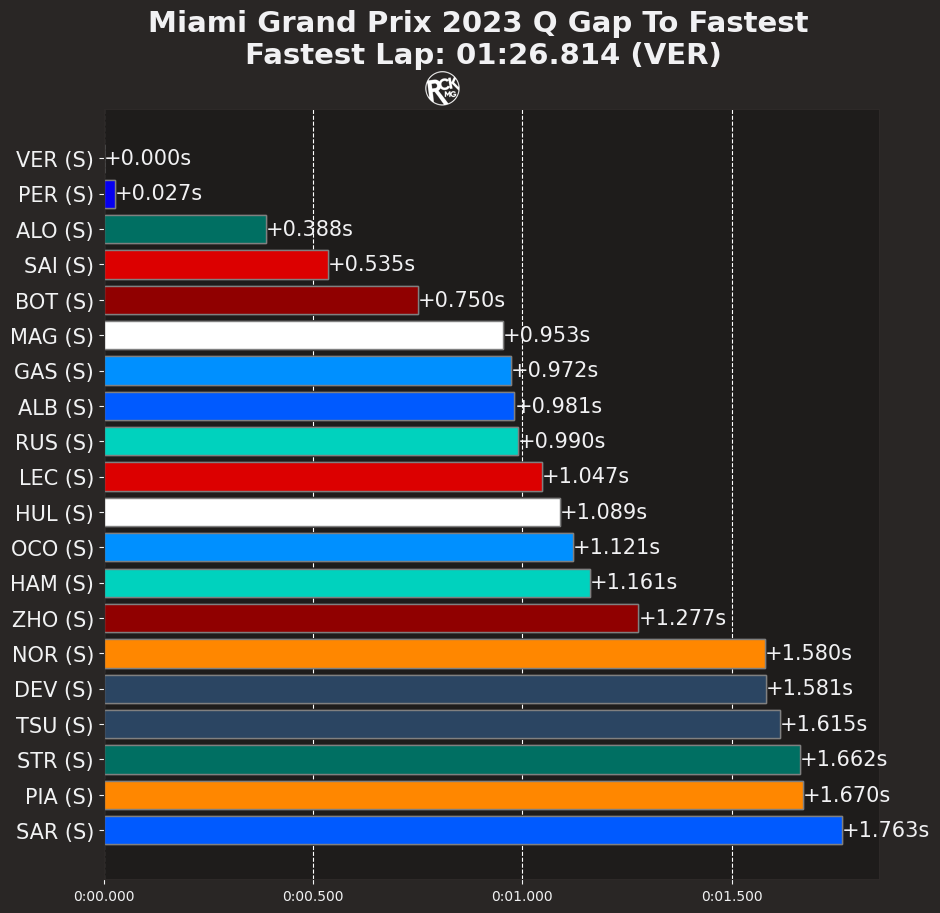

In [74]:
plt.rcParams['figure.figsize'] = plot_size
fig, ax = plt.subplots()
ax.barh(filtered_fastest_laps.index, filtered_fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(filtered_fastest_laps.index)
# Prepare ytick labels
ytick_labels = [f"{row['Driver']} ({row['Compound'][0]})"
                for _, row in filtered_fastest_laps.iterrows()]

ax.set_yticklabels(ytick_labels, fontsize=axis_label_font_size)

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='white', zorder=-1000)
lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')

plt.suptitle(plot_title, size=title_font_size, fontweight='bold')

#intervals(ax)
gap_to_leader(ax)
add_logo()


plt.show()